<a href="https://colab.research.google.com/github/Chxlz/DSA4213-Assignment-3/blob/main/DSA4213_A0259291W_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSA Assignment 3**

### **Logins**

In [1]:
from huggingface_hub import login
login()

import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chxlz (chxlz-national-university-of-singapore-students-union) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### **Install libraries and import packages**

In [20]:
# install libraries
!pip install -q transformers datasets peft accelerate evaluate torch matplotlib scikit-learn

# import
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

### **Load Dataset**

In [21]:
# load data
dataset = load_dataset("shawhin/phishing-site-classification")

# check data structure
print(dataset)

# see sample
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2100
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 450
    })
})
{'text': "http://bazurashop.com/idex.html?sfm_from_iframe=1',300,350", 'labels': 1}


### **Tokenize**

In [22]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"]
val_dataset   = tokenized_datasets["validation"]
test_dataset  = tokenized_datasets["test"]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

### **Evaluation helper function**

In [23]:
# load metrics
accuracy_metric  = evaluate.load("accuracy")
f1_metric        = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
roc_metric       = evaluate.load("roc_auc")

# evaluation helper function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()  # phising = 1, legit = 0

    accuracy  = accuracy_metric.compute(predictions=preds, references=labels)
    f1        = f1_metric.compute(predictions=preds, references=labels, average="macro")
    precision = precision_metric.compute(predictions=preds, references=labels, average="macro")
    recall    = recall_metric.compute(predictions=preds, references=labels, average="macro")
    roc_auc   = roc_metric.compute(prediction_scores=probs, references=labels)

    return {
        "accuracy":  accuracy["accuracy"],
        "macro_f1":  f1["f1"],
        "precision": precision["precision"],
        "recall":    recall["recall"],
        "roc_auc":   roc_auc["roc_auc"],
    }

### **Train Full Finetune BERT**

In [24]:
# load pretrained BERT
model_full = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# training arguments
training_args_full = TrainingArguments(
    output_dir="results_full",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs_full",
)

# trainer object
trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# train
trainer_full.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,Roc Auc
1,No log,0.258661,0.895556,0.895555,0.895563,0.895556,0.969719
2,No log,0.260404,0.917778,0.917481,0.923882,0.917778,0.979042
3,No log,0.280552,0.935556,0.935484,0.937500,0.935556,0.980958


TrainOutput(global_step=396, training_loss=0.23636661876331677, metrics={'train_runtime': 84.3084, 'train_samples_per_second': 74.726, 'train_steps_per_second': 4.697, 'total_flos': 207199956096000.0, 'train_loss': 0.23636661876331677, 'epoch': 3.0})

### **Train LoRA (Rank=4) Fine-Tune BERT**

In [25]:
# load pretrained BERT
model_lora4 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# lora rank 4
lora_config4 = LoraConfig(
    r=4, lora_alpha=16, target_modules=["query", "value"],
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)
model_lora4 = get_peft_model(model_lora4, lora_config4)

# training arguments
training_args_lora4 = TrainingArguments(
    output_dir="results_lora4",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs_lora4",
)

# trainer object
trainer_lora4 = Trainer(
    model=model_lora4,
    args=training_args_lora4,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# train
print("training lora r=4 model...")
trainer_lora4.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training lora r=4 model...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,Roc Auc
1,No log,0.377698,0.842222,0.842184,0.842554,0.842222,0.910775
2,No log,0.329247,0.873333,0.873192,0.875000,0.873333,0.930193
3,No log,0.322298,0.877778,0.877560,0.880491,0.877778,0.933590


TrainOutput(global_step=396, training_loss=0.44101271966491085, metrics={'train_runtime': 63.2421, 'train_samples_per_second': 99.617, 'train_steps_per_second': 6.262, 'total_flos': 207560402380800.0, 'train_loss': 0.44101271966491085, 'epoch': 3.0})

### **Train LoRA (Rank=8) Fine-Tune BERT**

In [26]:
# load pretrained BERT
model_lora8 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# lora rank 8
lora_config8 = LoraConfig(
    r=8, lora_alpha=16, target_modules=["query", "value"],
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)
model_lora8 = get_peft_model(model_lora8, lora_config8)

# training arguments
training_args_lora8 = TrainingArguments(
    output_dir="results_lora8",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs_lora8",
)

# training object
trainer_lora8 = Trainer(
    model=model_lora8,
    args=training_args_lora8,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# train
print("training lora r=8 model...")
trainer_lora8.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training lora r=8 model...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,Roc Auc
1,No log,0.380583,0.840000,0.840000,0.840000,0.840000,0.912988
2,No log,0.322829,0.877778,0.877676,0.879043,0.877778,0.933412
3,No log,0.317515,0.882222,0.882012,0.884967,0.882222,0.936553


TrainOutput(global_step=396, training_loss=0.43741688583836413, metrics={'train_runtime': 52.7672, 'train_samples_per_second': 119.392, 'train_steps_per_second': 7.505, 'total_flos': 207917127936000.0, 'train_loss': 0.43741688583836413, 'epoch': 3.0})

### **Train LoRA (Rank=16) Fine-Tune BERT**

In [27]:
# load pretrained BERT
model_lora16 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# lora rank 16
lora_config16 = LoraConfig(
    r=16, lora_alpha=16, target_modules=["query", "value"],
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)
model_lora16 = get_peft_model(model_lora16, lora_config16)

# training arguments
training_args_lora16 = TrainingArguments(
    output_dir="results_lora16",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs_lora16",
)

# training object
trainer_lora16 = Trainer(
    model=model_lora16,
    args=training_args_lora16,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# train
print("training lora r=16 model...")
trainer_lora16.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training lora r=16 model...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,Roc Auc
1,No log,0.379236,0.844444,0.844444,0.844444,0.844444,0.912435
2,No log,0.324644,0.873333,0.873228,0.874584,0.873333,0.932504
3,No log,0.319614,0.873333,0.873107,0.876015,0.873333,0.935269


TrainOutput(global_step=396, training_loss=0.43660242870600535, metrics={'train_runtime': 57.9704, 'train_samples_per_second': 108.676, 'train_steps_per_second': 6.831, 'total_flos': 208630579046400.0, 'train_loss': 0.43660242870600535, 'epoch': 3.0})

### **Evaluate Models**

In [28]:
# evaluate all trained models on test set
print("evaluating full fine-tuning model...")
full_results = trainer_full.evaluate(test_dataset)
print(full_results)

print("\nevaluating lora r=4 model...")
lora4_results = trainer_lora4.evaluate(test_dataset)
print(lora4_results)

print("\nevaluating lora r=8 model...")
lora8_results = trainer_lora8.evaluate(test_dataset)
print(lora8_results)

print("\nevaluating lora r=16 model...")
lora16_results = trainer_lora16.evaluate(test_dataset)
print(lora16_results)

evaluating full fine-tuning model...


{'eval_loss': 0.2610201835632324, 'eval_accuracy': 0.9266666666666666, 'eval_macro_f1': 0.9266373215953048, 'eval_precision': 0.9286110670683367, 'eval_recall': 0.9273152996502598, 'eval_roc_auc': 0.9814262285364262, 'eval_runtime': 1.6186, 'eval_samples_per_second': 278.016, 'eval_steps_per_second': 17.917, 'epoch': 3.0}

evaluating lora r=4 model...


{'eval_loss': 0.36136817932128906, 'eval_accuracy': 0.8555555555555555, 'eval_macro_f1': 0.8555491355171341, 'eval_precision': 0.8561768427712748, 'eval_recall': 0.8559445948349107, 'eval_roc_auc': 0.9223260684858424, 'eval_runtime': 1.6907, 'eval_samples_per_second': 266.168, 'eval_steps_per_second': 17.153, 'epoch': 3.0}

evaluating lora r=8 model...


{'eval_loss': 0.3617532551288605, 'eval_accuracy': 0.8533333333333334, 'eval_macro_f1': 0.853307254623044, 'eval_precision': 0.8544285007422068, 'eval_recall': 0.8538402260467506, 'eval_roc_auc': 0.9225631804619733, 'eval_runtime': 1.7111, 'eval_samples_per_second': 262.99, 'eval_steps_per_second': 16.948, 'epoch': 3.0}

evaluating lora r=16 model...


{'eval_loss': 0.3592308759689331, 'eval_accuracy': 0.8511111111111112, 'eval_macro_f1': 0.8510927274972219, 'eval_precision': 0.8520299145299146, 'eval_recall': 0.8515777826078366, 'eval_roc_auc': 0.9238672963306922, 'eval_runtime': 1.7227, 'eval_samples_per_second': 261.22, 'eval_steps_per_second': 16.834, 'epoch': 3.0}


In [29]:
# create results table
data = {
    "model": ["full fine-tune", "lora r=4", "lora r=8", "lora r=16"],
    "accuracy": [full_results["eval_accuracy"], lora4_results["eval_accuracy"], lora8_results["eval_accuracy"], lora16_results["eval_accuracy"]],
    "f1": [full_results["eval_macro_f1"], lora4_results["eval_macro_f1"], lora8_results["eval_macro_f1"], lora16_results["eval_macro_f1"]],
    "precision": [full_results["eval_precision"], lora4_results["eval_precision"], lora8_results["eval_precision"], lora16_results["eval_precision"]],
    "recall": [full_results["eval_recall"], lora4_results["eval_recall"], lora8_results["eval_recall"], lora16_results["eval_recall"]],
    "roc_auc": [full_results["eval_roc_auc"], lora4_results["eval_roc_auc"], lora8_results["eval_roc_auc"], lora16_results["eval_roc_auc"]],
}

df = pd.DataFrame(data)
print(df.round(4))

            model  accuracy      f1  precision  recall  roc_auc
0  full fine-tune    0.9267  0.9266     0.9286  0.9273   0.9814
1        lora r=4    0.8556  0.8555     0.8562  0.8559   0.9223
2        lora r=8    0.8533  0.8533     0.8544  0.8538   0.9226
3       lora r=16    0.8511  0.8511     0.8520  0.8516   0.9239


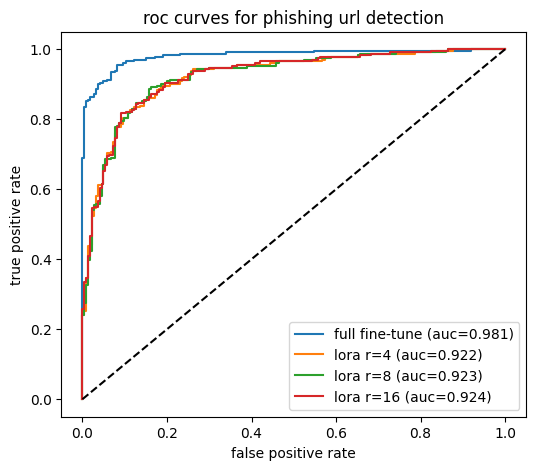

In [30]:
# plot roc curves for all 4 models
def get_probs_and_labels(trainer, dataset):
    preds = trainer.predict(dataset)
    logits = preds.predictions
    labels = preds.label_ids
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    return probs, labels

# get predicted probabilities for each model
probs_full,  labels = get_probs_and_labels(trainer_full,  test_dataset)
probs_lora4, _      = get_probs_and_labels(trainer_lora4, test_dataset)
probs_lora8, _      = get_probs_and_labels(trainer_lora8, test_dataset)
probs_lora16, _     = get_probs_and_labels(trainer_lora16, test_dataset)

# compute roc curves
fpr_full,  tpr_full,  _ = roc_curve(labels, probs_full)
fpr_lora4, tpr_lora4, _ = roc_curve(labels, probs_lora4)
fpr_lora8, tpr_lora8, _ = roc_curve(labels, probs_lora8)
fpr_lora16, tpr_lora16, _ = roc_curve(labels, probs_lora16)

# compute auc scores
roc_auc_full  = auc(fpr_full,  tpr_full)
roc_auc_lora4 = auc(fpr_lora4, tpr_lora4)
roc_auc_lora8 = auc(fpr_lora8, tpr_lora8)
roc_auc_lora16 = auc(fpr_lora16, tpr_lora16)

# plot all roc curves
plt.figure(figsize=(6,5))
plt.plot(fpr_full,  tpr_full,  label=f"full fine-tune (auc={roc_auc_full:.3f})")
plt.plot(fpr_lora4, tpr_lora4, label=f"lora r=4 (auc={roc_auc_lora4:.3f})")
plt.plot(fpr_lora8, tpr_lora8, label=f"lora r=8 (auc={roc_auc_lora8:.3f})")
plt.plot(fpr_lora16, tpr_lora16, label=f"lora r=16 (auc={roc_auc_lora16:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("roc curves for phishing url detection")
plt.legend()
plt.show()

### **Errors Analysis: Comparing LoRA (r=16) Misclassifications vs Full Fine-Tune**

In [31]:
# helper to get predictions and labels
def get_preds_and_labels(trainer, dataset):
    preds = trainer.predict(dataset)
    logits = preds.predictions
    labels = preds.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds_cls = np.argmax(probs, axis=-1)
    return preds_cls, labels, probs

In [41]:
# get predictions for both models
full_preds, full_labels, full_probs = get_preds_and_labels(trainer_full, test_dataset)
lora16_preds, _, lora16_probs = get_preds_and_labels(trainer_lora16, test_dataset)

# identify where full fine-tune correct, LoRA wrong
mask = (full_preds == full_labels) & (lora16_preds != full_labels)

# convert test set back to DataFrame for inspection
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["labels"]

df_errors = pd.DataFrame({
    "text": np.array(test_texts)[mask],
    "true_label": np.array(test_labels)[mask],
    "full_pred": full_preds[mask],
    "lora_pred": lora16_preds[mask],
    "full_prob_phish": full_probs[mask][:,1],
    "lora_prob_phish": lora16_probs[mask][:,1],
})

print("Number of samples where Full FT correct but LoRA r=16 wrong:", len(df_errors))
df_errors

Number of samples where Full FT correct but LoRA r=16 wrong: 41


,text,true_label,full_pred,lora_pred,full_prob_phish,lora_prob_phish
0,www.hydroenergie.fr/yzhhkit,1,1,0,0.961378,0.308766
1,www.stadtbetriebe-ahrensburg.de/content/stadtb...,1,1,0,0.990538,0.197422
2,www.arturschneider.de/ldap.html,0,0,1,0.012247,0.597045
3,oac.cdlib.org/view?docId=tf6f59n8gm&view=dsc&s...,0,0,1,0.006783,0.965742
4,torrentreactor.net/search.php?search=2&words=f...,0,0,1,0.004324,0.769146
5,amazon.com/Zelary-Anna-Geislerov%C3%A1/dp/B000...,0,0,1,0.003165,0.544801
6,thefreedictionary.com/action+deferred,0,0,1,0.003952,0.849314
7,music-releases.com/release/416836/Jean%20Schwa...,0,0,1,0.009170,0.927555
8,fliiby.com/search.php?q=frank%2C+garrett%2C+du...,0,0,1,0.003487,0.573344
9,animals.mizemlyaki.ru/templates/https/www.itau...,1,1,0,0.976511,0.214728
